This Notebook contains:
1- Online Data Collection
2- Cleaning & Validation
3- Exploratory Data Analysis(EDA)
4- KPI definition & SQL examples
5- Documenting data quality


Imports

In [1]:
import os # Privides functions to interact within operating system(file and directory operations, path handeing, reading envoirment variables) 
import json # reading json files, converting python files to json, parsing json responses from APIs
import sqlite3 # for Creating local database
from datetime import datetime 
from typing import List, Dict, Tuple # use to define data type, IDE autocompletion
import pandas as pd
import requests 
from bs4  import BeautifulSoup #HTML/XML parser used for web scraping
from sqlalchemy import create_engine, text #Creates a connection engine to a database
import matplotlib.pyplot as plt
import random

Configuration

In [2]:
Data_dir = "data"
os.makedirs(Data_dir, exist_ok=True) #creats folder, if not exist 
#jsonplaceholder_api_configuration
Api_config = {"base_url":"https://jsonplaceholder.typicode.com",
             "auth_token": None}
#SQLite(connecting to data warehouse)
sqlite_db = os.path.join(Data_dir,"warehouse.db")
print(os.path.abspath(sqlite_db))

C:\Users\User\data\warehouse.db


Data_collection: Scrapping, Rest APIs, CVS,DB

In [3]:
def fetch_webpage(url: str, timeout: int = 10) -> str:  #Fetching HTML text
    resp = requests.get(url, timeout= timeout)
    resp.raise_for_status() #Checks the HTTP status code of the response.(e.g, error 404)
    return resp.text  #returns raw HTML
    
def parse_product_table_from_html(html: str) -> pd.DataFrame:
    soup = BeautifulSoup(html,"html.parser")
    rows = []
    table = soup.find("table",{"class":"product"})
    if not table:
        return pd.DataFrame()
    header_cell = [th.get_text(strips = True) for th in tables.find_all("th")] #th:tableheader
    for tr in table.find_all("tr"):
        cells = [td.get_text(strips= True) for th in table.find_all("td")] #td:Table cells
        if cells:
            rows.append(cells)
        if rows:
            return pd.Dataframe(rows,colums = header_cells)
            return pd.DataFrame()


API pulling with JSON

In [4]:
# This function takes an API endpoint, optional parameters, and config, 
#sends an authenticated GET request, checks for errors, and 
#returns the response as a dictionary
def fetch_api(endpoint: str,params: Dict = None, config: Dict = Api_config) -> Dict:
    headers = {"Authorization": f"Bearer{config.get('auth_token')}"} #config.get('auth_token') → get is safer than config['auth_token'] because it won’t crash if the key doesn’t exist; it will return None instead.
    url = f"{config.get('base_url').rstrip('/')}/{endpoint.Istrip('/')}"
    r = requests.get(url,headers=headers, param=param,timeout=20)
    r.raise_for_status() #Checks if the HTTP request returned an error. If the status code is 4xx or 5xx (client/server error), it raises an exception.
    return r.json() #from JSON into a Python dictionary.

Reading ERP/CRM CSV exports

In [5]:
def read_csv_export(path: str,**kwargs)-> pd.DataFrame:
    return pd.read_csv(pathh, **kwargs) #**kwargs → This Python feature allows us to pass any. e.g, read_csv_export("data.csv", sep=";", encoding="utf-8") 
    

Connecting SQLite

In [6]:
#this function will simulate the data warehouse
def get_sqlalchemy_engine(sqlite_path: str = sqlite_db): #here we can add our datapase path as a string. here it is defaultly set as "sqlite_db" 
    engine = create_engine(f"sqlite:///{sqlite_path}") #{sqlite_path} here we add out dataset path
    return engine
    
#this function will allow to run sql querries
def run_sql(query: str, engine=None)-> pd.DataFrame: #here we can add our engine, we wantto connect. if not given then next command
    if engine is None:
        engine = get_sqlalchemy_engine() 
    with engine.connect() as conn:  # "with" ensures the connection is automatically closed after the block, even if an error occurs.
        df = pd.read_sql_query(text(query), conn)
    return df

creating sample data in the simulated warehouse

In [7]:
def create_wh(sqlite_path: str = sqlite_db):
    engine = get_sqlalchemy_engine(sqlite_path)

    # --- Customers table (fixed lengths: 5 rows) ---
    customers = pd.DataFrame(
        {
            "Id": ["C101", "B202", "A303", "D404", "E505"],
            "Name": ["Orion Inc", "Luna Tech", "Zenith Co", "Aurora Ltd", "Solace Enterprises"],
            "Region": ["North America", "South America", "Europe", "Middle East", "Asia-Pacific"],
            "Created_at": pd.to_datetime([
                "2025-10-11",
                "2025-09-11"
                "2025-08-11",
                "2025-07-11",
                "2025-06-11",
            ]),
        }
    )

    # --- Orders table (100 rows) ---
    order_ids = list(range(1, 101))
    customer_ids = [random.choice(["C101", "B202", "A303", "D404", "E505"]) for _ in range(100)]
    order_dates = [pd.Timestamp("2025-07-11") + pd.Timedelta(days=i) for i in range(100)]
    amounts = [round(random.uniform(50, 3000), 2) for _ in range(100)]
    statuses = [
        random.choice(["ordered", "shipped", "pending", "cancelled", "returned"])
        for _ in range(100)
    ]

    orders = pd.DataFrame(
        {
            "order_id": order_ids,
            "customer_id": customer_ids,
            "order_date": order_dates,
            "amount": amounts,
            "status": statuses,
        }
    )

    # --- Save to SQLite ---
    with engine.begin() as conn:
        customers.to_sql("customers", conn, if_exists="replace", index=False)
        orders.to_sql("orders", conn, if_exists="replace", index=False)

    print(f"Order warehouse is created at {sqlite_path}")
#create_wh()

Cleaning & Validation function: This function will perform stardard cleaning step i.e stripping strings, normalizing coliumns names, converting dates and numerical dta types.


In [8]:
def clean(df:pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
#normalizing column names
    df.columns = [c.strip().lower().replace("","_") for c in df.columns]
#strip strings
    for col in df.select_dtypes(include=["object"]).columns:
        df[col] = df[col].str.strip()
#parsing data-like columns
    for col in df.columns:
        if col.columns("dtae") or col.endswith("_at"):
            try:
                df[col] = pd.to_datetime(df[col], errors = "coerce") #"coerce" helps the conversion and convert the complex dtapes into "nan"
            except exception:
                pass
#coerce numerical columns
    for col in df.columns:
        if df[col].dtype == "object":
            coerced = pd.to_numerical(df[col].str.replace(',',''), errors = "coerce")#numerical conversion if parseable
            notnull_share = coerced.notna().mean()
            if notnull_share > 0.7:
                df[col] = coerced
    return df
    
            
    

Function for quality checks

In [9]:
def data_quality(df: pd.DataFrame)-> pd.DataFrame:
    report = []
    n = len(df)
    for col in df.columns:
        series = df[col]
        report.append(
            {
            "column" : col,
        "dtype" : str(series,dtype),
        "n_missing" : int(series.isna().sum()),
        "pct_missing": float(series,isna().mean()),
        "n_unique" : int(series.nunique(dropna=True)),
        "values" : json.dumps(list(series.dropna().unique()[:5]), default = str),
            })
        return pd.DataFrame(report)

Simple KPI definitions and SQL queries:a set of standard SQL queries for common BI KPIs: revenue over time, average order value, churn rate (simple), top customers.

In [25]:
sql_rotal_rev_monthly = """
SELECT
    strftime('%Y-%m', date(order_date)) AS year_month,
    COUNT(order_id) AS orders_count,
    SUM(amount) AS total_revenue,
    AVG(amount) AS avg_order_value
FROM orders
WHERE status = 'shipped'
GROUP BY year_month
ORDER BY year_month;

"""
sql_top_customers = """
SELECT 
    c.Id AS customer_id,
    c.Name AS customer_name,
    c.Region,
    SUM(o.amount) AS total_revenue,
    COUNT(o.order_id) AS total_orders
FROM customers c
JOIN orders o 
    ON TRIM(c.Id) = TRIM(o.customer_id) 
WHERE o.status = 'shipped'
GROUP BY c.Id, c.Name, c.Region
ORDER BY total_revenue DESC
LIMIT 10;

"""
#selcting customers with orders in period A but none in period B
sql_churn ="""
WITH period_a AS(
    SELECT DISTINCT customer_id FROM orders WHERE order_date BETWEEN '2025-10-11' AND '2025-09-11'),
    period_b AS(
    SELECT DISTINCT customer_id FROM orders WHERE order_date BETWEEN  '2025-08-11' AND '2025- 07-11'
    )
SELECT
    (SELECT COUNT (*) FROM period_a) as customer_in_a,
    (SELECT COUNT (*) FROM period_b) as customer_in_b,
    (SELECT COUNT(*) FROM period_a WHERE customer_id NOT IN (SELECT customer_id FROM period_b)) as curned_customer_count
;
"""



Using SQL KPIs and show results in pandas & plots

Running KPI: total revenue by month
  year_month  orders_count  total_revenue  avg_order_value
0    2025-07             1        2055.38      2055.380000
1    2025-08             1        1091.50      1091.500000
2    2025-09             3        4885.28      1628.426667
3    2025-10             4        6960.84      1740.210000


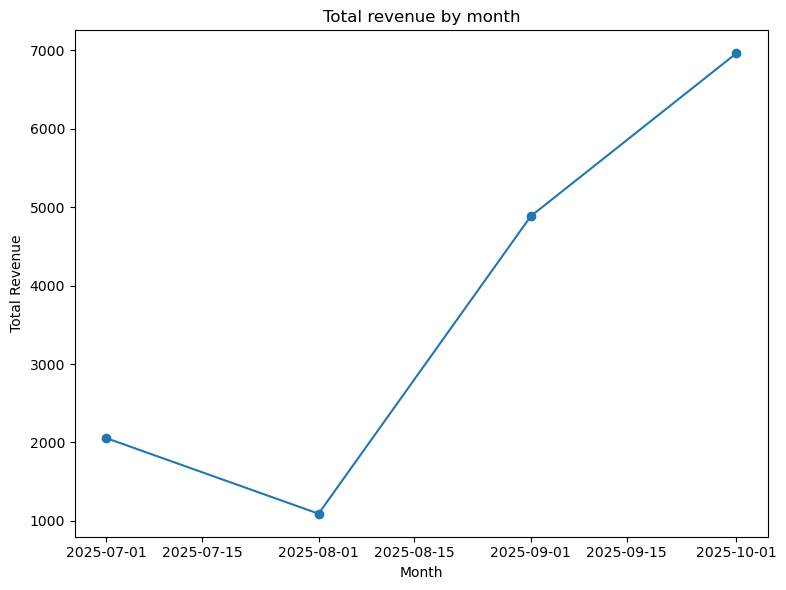


Top customers by revenue:
  customer_id       customer_name         Region  total_revenue  total_orders
0        C101           Orion Inc  North America        6592.00             4
1        B202           Luna Tech  South America        5613.48             4
2        E505  Solace Enterprises   Asia-Pacific        2787.52             1


In [26]:
engine = get_sqlalchemy_engine()
print('Running KPI: total revenue by month')
rev_df = run_sql(sql_rotal_rev_monthly, engine)
print(rev_df)
#plot
if not rev_df.empty:
    rev_df['year_month'] = pd.to_datetime(rev_df['year_month']+'-01')
    plt.figure(figsize = (8,6))
    plt.plot(rev_df['year_month'],rev_df['total_revenue'],marker = 'o')
    plt.title('Total revenue by month')
    plt.xlabel('Month')
    plt.ylabel('Total Revenue')
    plt.tight_layout()
    plt.show()
print('\nTop customers by revenue:')
print(run_sql(sql_top_customers, engine))

To check dataset info:

In [27]:
print(run_sql("PRAGMA table_info(customers);", engine))
print(run_sql("PRAGMA table_info(orders);", engine))


   cid        name      type  notnull dflt_value  pk
0    0          Id      TEXT        0       None   0
1    1        Name      TEXT        0       None   0
2    2      Region      TEXT        0       None   0
3    3  Created_at  DATETIME        0       None   0
   cid         name      type  notnull dflt_value  pk
0    0     order_id    BIGINT        0       None   0
1    1  customer_id      TEXT        0       None   0
2    2   order_date  DATETIME        0       None   0
3    3       amount     FLOAT        0       None   0
4    4       status      TEXT        0       None   0


Documenting & automating report

In [31]:
def export_report(df: pd.DataFrame, name: str) -> str:
    """Save the DataFrame to CSV and Excel for BI tools"""
    
    ts = datetime.utcnow().strftime('%Y%m%dT%H%M%SZ') 
    csv_path = os.path.join(Data_dir, f"{name}_{ts}.csv")
    xlsx_path = os.path.join(Data_dir, f"{name}_{ts}.xlsx")
    
    df.to_csv(csv_path, index=False)
    df.to_excel(xlsx_path, index=False)
    
    return csv_path
report_path = export_report(rev_df, 'kpi_revenue_by_month')
print(f"Exported report to {report_path}")

Exported report to data\kpi_revenue_by_month_20251201T100809Z.csv


Using the above funtion to write a simple metadata log documenting the report

In [34]:
metadata = {
'report_name': 'kpi_revenue_by_month',
'created_at': datetime.utcnow().isoformat() + 'Z',
'source': ['warehouse.orders', 'warehouse.customers'],
'rows': int(len(rev_df)),
}
with open(os.path.join(Data_dir, 'kpi_revenue_by_month_metadata.json'), 'w') as f:
    json.dump(metadata, f, indent=2)
print('Wrote metadata log')

Wrote metadata log


In [35]:
import json
with open(os.path.join(Data_dir, 'kpi_revenue_by_month_metadata.json')) as f:
    data = json.load(f)
data


{'report_name': 'kpi_revenue_by_month',
 'created_at': '2025-12-01T10:10:19.429369Z',
 'source': ['warehouse.orders', 'warehouse.customers'],
 'rows': 4}